In [1]:
print('hello world')

hello world


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.rc('savefig', dpi=100)
plt.rc('figure', figsize=(5,5))

In [4]:
import pandas as pd
import requests
import io

In [26]:
ref = pd.read_pickle('ref_sites.pickle')
ref

,nwac_region,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc
site_id,,,,,,,,,,,
651,Mt Hood,SNTL,OR,Mt Hood Test Site (651),NaN,1980-July,45.32,-121.72,5370,Clackamas,Upper Salmon River (170800010302)
974,Olympics,SNTL,WA,Waterhole (974),NaN,1999-October,47.94,-123.43,5010,Clallam,Lillian Creek (171100200506)
998,West Slopes North - Canadian Border to Skagit ...,SNTL,WA,Easy Pass (998),NaN,2008-September,48.86,-121.44,5270,Whatcom,Indian Creek-Chilliwack River (171100010101)
507,East Slopes Central - Lake Chelan to South of ...,SNTL,WA,Grouse Camp (507),NaN,1980-September,47.28,-120.49,5390,Kittitas,Upper Naneum Creek (170300010401)
679,West Slopes South - South of I-90 to Columbia ...,SNTL,WA,Paradise (679),NaN,1980-September,46.78,-121.75,5130,Pierce,Headwaters Nisqually River (171100150104)
599,East Slopes South - South of I-90 to Columbia ...,SNTL,WA,Lost Horse (599),NaN,1989-October,46.36,-121.08,5120,Yakima,Upper Simcoe Creek (170300030302)


# Download USDA data

TODO: trim down to datetime increments

In [5]:
import pytz

pacific = pytz.timezone('US/Pacific')

def tzconvert(datetime, from_tz, to_tz):
    aware = from_tz.localize(datetime)
    return aware.astimezone(to_tz).replace(tzinfo=None)

In [213]:
def get_usda_hourly(site, range_min, range_max, state='WA'):
    # all USDA times are LOCAL TIME (PDT/PST)
    
    cols = ['WTEQ', 'SNWD', 'PREC', 'TOBS',]# 'TMAX', 'TMIN', 'TAVG']
    # water equivalent, snow depth, precipitation, observed temperature,
    cols = [
        ('WTEQ','value'),
        ('SNWD','value'),
        ('PREC','value'),
        ('TOBS','value'),
        ]

    colstring = ','.join('{}::{}'.format(name,avg) for name,avg in cols)
    coltitles = ['Date',] + list('{}_{}'.format(name,avg) for name,avg in cols)

    fmt = ('http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/'
           'customSingleStationReport/hourly/{site}:{state}:SNTL/{range_min},{range_max}/{columns}')
    
    # convert these to strings.
    # the bound granularity is only by day, not by hour.
    range_min, range_max = (bound.strftime('%Y-%m-%d')
                            for bound in (range_min, range_max))
    
    url = fmt.format(range_min=range_min,
                     range_max=range_max,
                     columns=colstring, site=site, state=state)

    r = requests.get(url)

    # parse dataframe
    df = pd.read_csv(io.StringIO(r.text), comment='#')
    
    # shorten column labels
    collabels = df.columns
    df.columns = coltitles
    
    # cheat sheet for column labels
    for a,b in zip(coltitles,collabels):
        #print("{}:{}".format(a,b))
        pass
    
    # as far as I can tell, dates are in pacific time. No idea whether DST is accounted for
    df['datetime_loc'] = pd.to_datetime(df['Date'])
    df['datetime_utc'] = pd.to_datetime(df['Date'] + ' PST')
    df = df.set_index('datetime_loc')
    return df 

In [8]:
range_min,range_max = pd.datetime(2014,12,31), pd.datetime(2015,1,31)

In [214]:
def gen_frames(range_min, range_max):
    for site_id in ref.index:
        state = ref.ix[site_id]['state']
        df = get_usda_hourly(site_id, range_min, range_max, state=state)
        yield df

dfs = pd.concat(list(gen_frames(range_min, range_max)), keys=ref.index, names=['site_id',])
dfs.head()

Date:Date
WTEQ_value:Snow Water Equivalent (in)
SNWD_value:Snow Depth (in)
PREC_value:Precipitation Accumulation (in)
TOBS_value:Air Temperature Observed (degF)
Date:Date
WTEQ_value:Snow Water Equivalent (in)
SNWD_value:Snow Depth (in)
PREC_value:Precipitation Accumulation (in)
TOBS_value:Air Temperature Observed (degF)
Date:Date
WTEQ_value:Snow Water Equivalent (in)
SNWD_value:Snow Depth (in)
PREC_value:Precipitation Accumulation (in)
TOBS_value:Air Temperature Observed (degF)
Date:Date
WTEQ_value:Snow Water Equivalent (in)
SNWD_value:Snow Depth (in)
PREC_value:Precipitation Accumulation (in)
TOBS_value:Air Temperature Observed (degF)
Date:Date
WTEQ_value:Snow Water Equivalent (in)
SNWD_value:Snow Depth (in)
PREC_value:Precipitation Accumulation (in)
TOBS_value:Air Temperature Observed (degF)
Date:Date
WTEQ_value:Snow Water Equivalent (in)
SNWD_value:Snow Depth (in)
PREC_value:Precipitation Accumulation (in)
TOBS_value:Air Temperature Observed (degF)


Date  WTEQ_value  SNWD_value  \
site_id datetime_loc                                                    
651     2014-12-31 00:00:00  2014-12-31 00:00        12.1          44   
        2014-12-31 01:00:00  2014-12-31 01:00        12.0          45   
        2014-12-31 02:00:00  2014-12-31 02:00        12.0          44   
        2014-12-31 03:00:00  2014-12-31 03:00        12.0          45   
        2014-12-31 04:00:00  2014-12-31 04:00        12.0          44   

                             PREC_value  TOBS_value        datetime_utc  
site_id datetime_loc                                                     
651     2014-12-31 00:00:00        44.6          35 2014-12-31 08:00:00  
        2014-12-31 01:00:00        44.3          28 2014-12-31 09:00:00  
        2014-12-31 02:00:00        44.3          28 2014-12-31 10:00:00  
        2014-12-31 03:00:00        44.3          29 2014-12-31 11:00:00  
        2014-12-31 04:00:00        44.3          29 2014-12-31 12:00:00

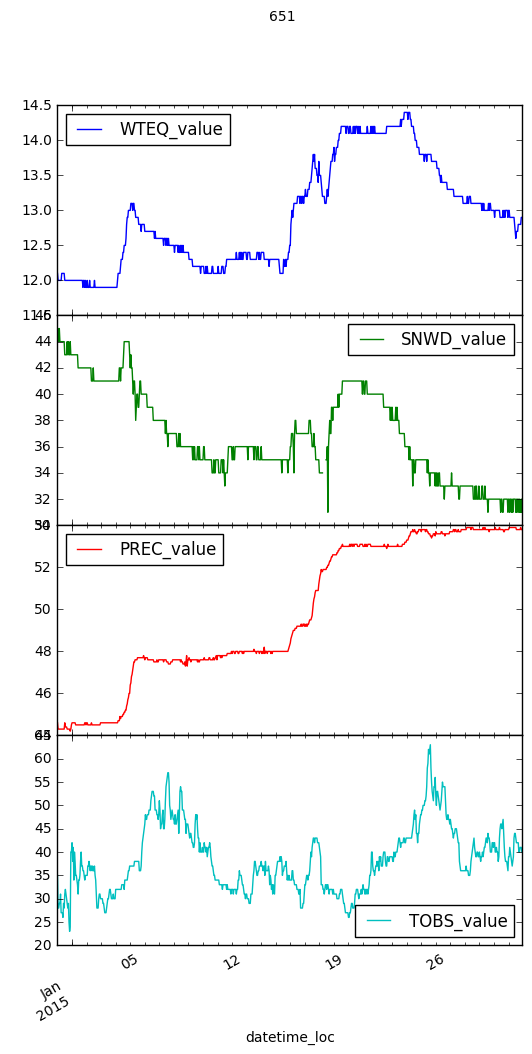

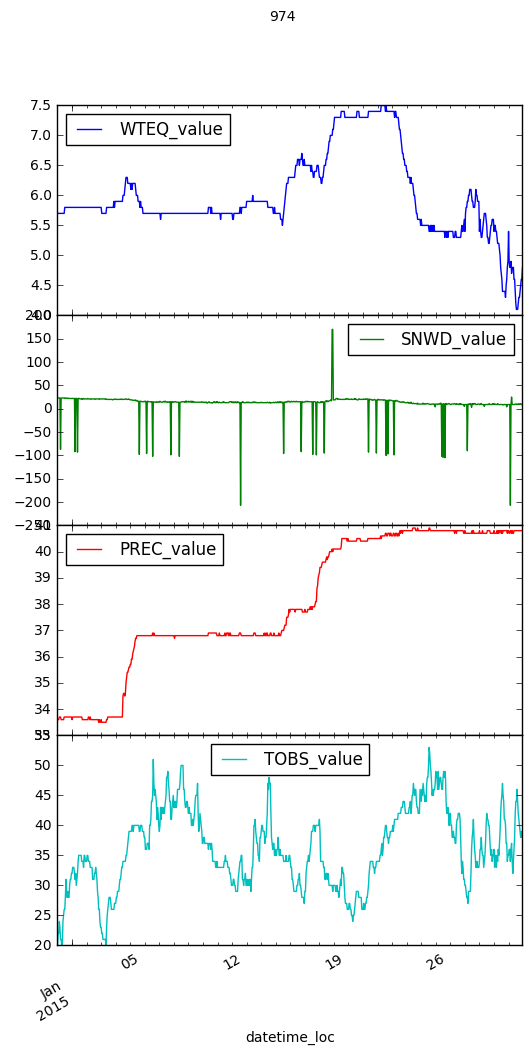

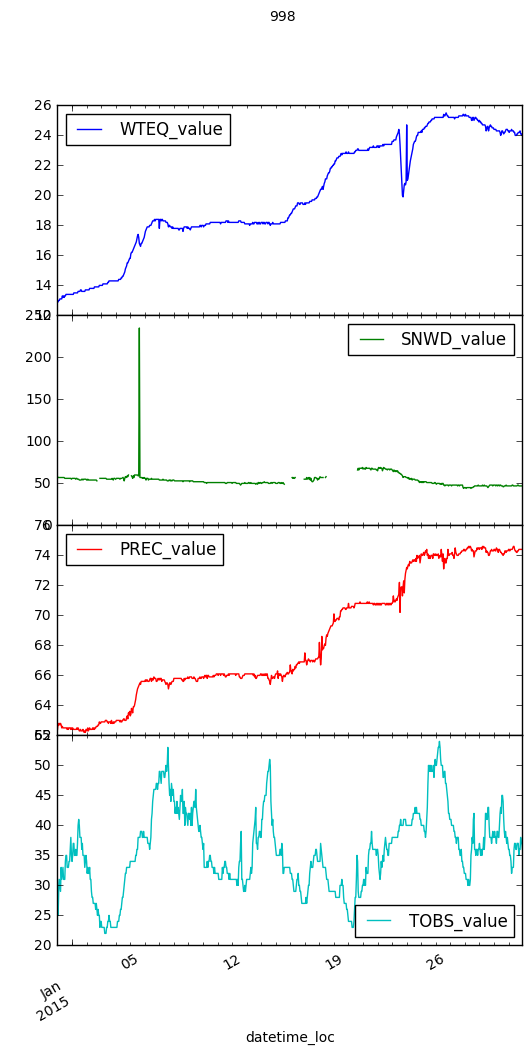

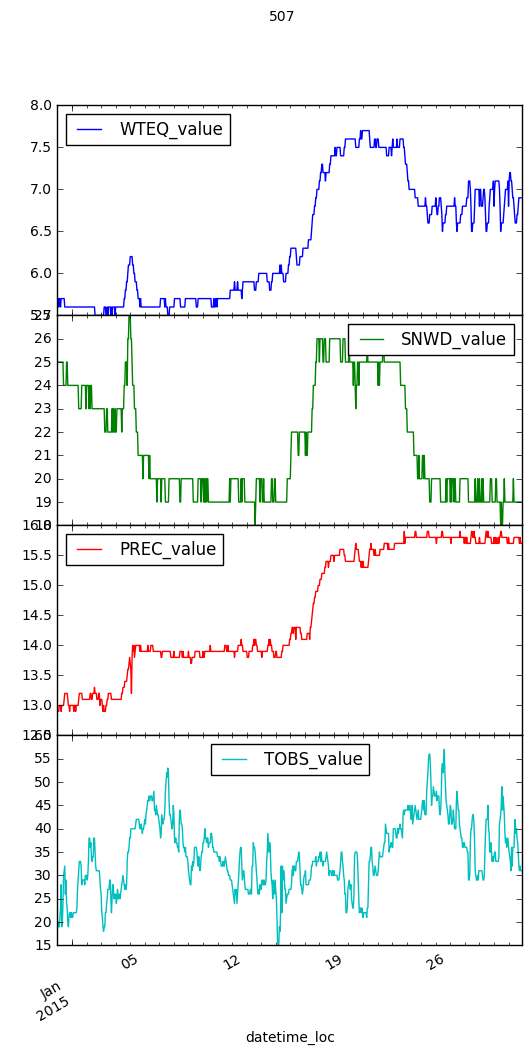

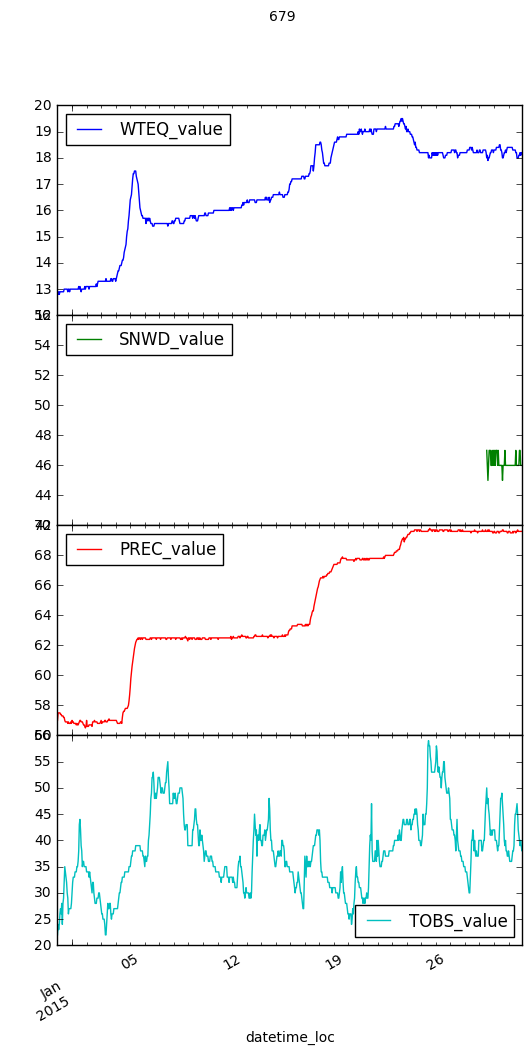

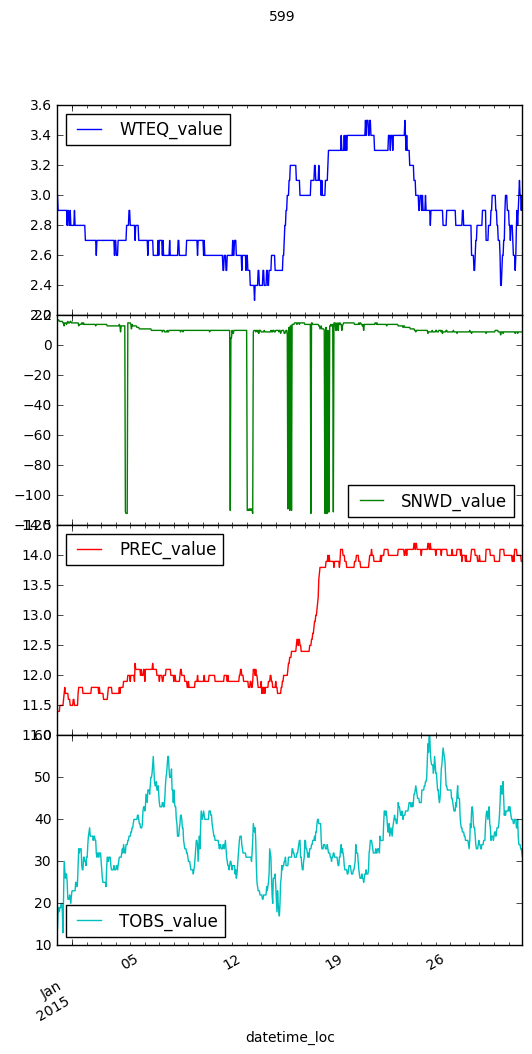

In [215]:
for site_id, df in dfs.groupby(level=0):
    plt.figure()
    df.index = df.index.droplevel(0)
    axes = df.plot(subplots=True, figsize=(6,12), legend=True)
    plt.subplots_adjust(hspace=0)
    plt.suptitle(site_id)
    #axes[-1].axhline(32, c='k', ls='--')

# NWAC ratings comparison



In [11]:
import sqlalchemy as sa

In [12]:
engine = sa.create_engine('postgres://%s@localhost/%s'%('tkb','avy'))
print(engine.url)

postgres://tkb@localhost/avy


In [13]:
metadata = sa.MetaData()

report_table = sa.Table('reports', metadata,
                        sa.Column('report_id', sa.Integer,
                                  primary_key=True, autoincrement=False),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.DateTime),
                          sa.Column('author', sa.Text),
                          sa.Column('region', sa.Text),
                          sa.Column('summary', sa.Text),
                          sa.Column('treeline_above', sa.Text),
                          sa.Column('treeline_near', sa.Text),
                          sa.Column('treeline_below', sa.Text),
                        )

In [15]:
def fetch_nwac_ratings(range_min, range_max, region='Mt Hood'):
    # this database uses utc
    stmt = sa.select([report_table]
                    ).where(
                        report_table.c.region == region
                    ).where(
                        report_table.c.datetime_utc <= range_max
                    ).where(
                        report_table.c.datetime_utc >= range_min
                    ).order_by(report_table.c.datetime_utc)

    df2 = pd.read_sql_query(stmt, engine)
    df2 = df2.set_index('datetime_utc')
    return df2

In [16]:
def fetch_nwac_ratings_localtime(range_min, range_max, region='Mt Hood'):
    # convert to utc
    utc_min,utc_max = (tzconvert(bound, pacific, pytz.utc) for bound in (range_min, range_max))
    # hit the database
    df2 = fetch_nwac_ratings(utc_min, utc_max, region=region)
    # reindex by local time
    df2['datetime_loc'] = df2.index.tz_localize(pytz.utc).tz_convert(pacific).tz_localize(None)
    df2 = df2.reset_index().set_index('datetime_loc')
    return df2

In [19]:
df2 = fetch_nwac_ratings_localtime(range_min, range_max)
df2.head()

,datetime_utc,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_loc,,,,,,,,,
2014-12-31 18:00:00,2015-01-01 02:00:00,994,"6:00 PM PST Wednesday, December 31, 2014",Kenny Kramer,Mt Hood,Recent N-NE winds have created some wind slab ...,Moderate,Moderate,Moderate
2015-01-01 18:00:00,2015-01-02 02:00:00,998,"6:00 PM PST Thursday, January 1, 2015",Garth Ferber,Mt Hood,Watch for lingering wind slab from early in th...,Moderate,Moderate,Moderate
2015-01-02 18:00:00,2015-01-03 02:00:00,1002,"6:00 PM PST Friday, January 2, 2015",Garth Ferber,Mt Hood,Watch mainly for lingering local wind slab fro...,Moderate,Moderate,Moderate
2015-01-03 17:52:00,2015-01-04 01:52:00,1006,"5:52 PM PST Saturday, January 3, 2015",Dennis D'Amico,Mt Hood,The avalanche danger will increase sharply by ...,Considerable,Considerable,Considerable
2015-01-04 17:35:00,2015-01-05 01:35:00,1010,"5:35 PM PST Sunday, January 4, 2015",Dennis D'Amico,Mt Hood,Dangerous avalanche conditions are expected Su...,Considerable,Considerable,Moderate


In [106]:
regions = ref['nwac_region']
frames = [fetch_nwac_ratings_localtime(range_min, range_max, region=region) for region in regions]
dfs2 = pd.concat(frames, keys=regions, names=['nwac_region',])
dfs2.head()

datetime_utc  report_id  \
nwac_region datetime_loc                                         
Mt Hood     2014-12-31 18:00:00 2015-01-01 02:00:00        994   
            2015-01-01 18:00:00 2015-01-02 02:00:00        998   
            2015-01-02 18:00:00 2015-01-03 02:00:00       1002   
            2015-01-03 17:52:00 2015-01-04 01:52:00       1006   
            2015-01-04 17:35:00 2015-01-05 01:35:00       1010   

                                                                 datetime  \
nwac_region datetime_loc                                                    
Mt Hood     2014-12-31 18:00:00  6:00 PM PST Wednesday, December 31, 2014   
            2015-01-01 18:00:00     6:00 PM PST Thursday, January 1, 2015   
            2015-01-02 18:00:00       6:00 PM PST Friday, January 2, 2015   
            2015-01-03 17:52:00     5:52 PM PST Saturday, January 3, 2015   
            2015-01-04 17:35:00       5:35 PM PST Sunday, January 4, 2015   

                                         author   region  \
nwac_region datetime_loc                                   
Mt Hood     2014-12-31 18:00:00    Kenny Kramer  Mt Hood   
            2015-01-01 18:00:00    Garth Ferber  Mt Hood   
            2015-01-02 18:00:00    Garth Ferber  Mt Hood   
            2015-01-03 17:52:00  Dennis D'Amico  Mt Hood   
            2015-01-04 17:35:00  Dennis D'Amico  Mt Hood   

                                                                           summary  \
nwac_region datetime_loc                                                             
Mt Hood     2014-12-31 18:00:00  Recent N-NE winds have created some wind slab ...   
            2015-01-01 18:00:00  Watch for lingering wind slab from early in th...   
            2015-01-02 18:00:00  Watch mainly for lingering local wind slab fro...   
            2015-01-03 17:52:00  The avalanche danger will increase sharply by ...   
            2015-01-04 17:35:00  Dangerous avalanche conditions are expected Su...   

                                treeline_above treeline_near treeline_below  
nwac_region datetime_loc                                                     
Mt Hood     2014-12-31 18:00:00       Moderate      Moderate       Moderate  
            2015-01-01 18:00:00       Moderate      Moderate       Moderate  
            2015-01-02 18:00:00       Moderate      Moderate       Moderate  
            2015-01-03 17:52:00   Considerable  Considerable   Considerable  
            2015-01-04 17:35:00   Considerable  Considerable       Moderate

In [154]:
len(dfs2)

124

In [107]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']

In [152]:
# convert to a numerical rating
ratdict = {rat:i for i,rat in enumerate(ratings)}

ratings_to_numbers = {'treeline_above':ratdict,
            'treeline_below':ratdict,
            'treeline_near':ratdict,}

dfsn = dfs2.replace(ratings_to_numbers)
dfsn.head()

datetime_utc  report_id  \
nwac_region datetime_loc                                         
Mt Hood     2014-12-31 18:00:00 2015-01-01 02:00:00        994   
            2015-01-01 18:00:00 2015-01-02 02:00:00        998   
            2015-01-02 18:00:00 2015-01-03 02:00:00       1002   
            2015-01-03 17:52:00 2015-01-04 01:52:00       1006   
            2015-01-04 17:35:00 2015-01-05 01:35:00       1010   

                                                                 datetime  \
nwac_region datetime_loc                                                    
Mt Hood     2014-12-31 18:00:00  6:00 PM PST Wednesday, December 31, 2014   
            2015-01-01 18:00:00     6:00 PM PST Thursday, January 1, 2015   
            2015-01-02 18:00:00       6:00 PM PST Friday, January 2, 2015   
            2015-01-03 17:52:00     5:52 PM PST Saturday, January 3, 2015   
            2015-01-04 17:35:00       5:35 PM PST Sunday, January 4, 2015   

                                         author   region  \
nwac_region datetime_loc                                   
Mt Hood     2014-12-31 18:00:00    Kenny Kramer  Mt Hood   
            2015-01-01 18:00:00    Garth Ferber  Mt Hood   
            2015-01-02 18:00:00    Garth Ferber  Mt Hood   
            2015-01-03 17:52:00  Dennis D'Amico  Mt Hood   
            2015-01-04 17:35:00  Dennis D'Amico  Mt Hood   

                                                                           summary  \
nwac_region datetime_loc                                                             
Mt Hood     2014-12-31 18:00:00  Recent N-NE winds have created some wind slab ...   
            2015-01-01 18:00:00  Watch for lingering wind slab from early in th...   
            2015-01-02 18:00:00  Watch mainly for lingering local wind slab fro...   
            2015-01-03 17:52:00  The avalanche danger will increase sharply by ...   
            2015-01-04 17:35:00  Dangerous avalanche conditions are expected Su...   

                                 treeline_above  treeline_near  treeline_below  
nwac_region datetime_loc                                                        
Mt Hood     2014-12-31 18:00:00               2              2               2  
            2015-01-01 18:00:00               2              2               2  
            2015-01-02 18:00:00               2              2               2  
            2015-01-03 17:52:00               3              3               3  
            2015-01-04 17:35:00               3              3               2

In [153]:
len(dfsn)

124

join to get site id column

In [186]:
dfsm = pd.merge(dfsn.reset_index(), ref[['nwac_region', 'elev',]].reset_index(),
                on='nwac_region', how='left').set_index(['nwac_region', 'datetime_loc'])
dfsm.head()

datetime_utc  report_id  \
nwac_region datetime_loc                                         
Mt Hood     2014-12-31 18:00:00 2015-01-01 02:00:00        994   
            2015-01-01 18:00:00 2015-01-02 02:00:00        998   
            2015-01-02 18:00:00 2015-01-03 02:00:00       1002   
            2015-01-03 17:52:00 2015-01-04 01:52:00       1006   
            2015-01-04 17:35:00 2015-01-05 01:35:00       1010   

                                                                 datetime  \
nwac_region datetime_loc                                                    
Mt Hood     2014-12-31 18:00:00  6:00 PM PST Wednesday, December 31, 2014   
            2015-01-01 18:00:00     6:00 PM PST Thursday, January 1, 2015   
            2015-01-02 18:00:00       6:00 PM PST Friday, January 2, 2015   
            2015-01-03 17:52:00     5:52 PM PST Saturday, January 3, 2015   
            2015-01-04 17:35:00       5:35 PM PST Sunday, January 4, 2015   

                                         author   region  \
nwac_region datetime_loc                                   
Mt Hood     2014-12-31 18:00:00    Kenny Kramer  Mt Hood   
            2015-01-01 18:00:00    Garth Ferber  Mt Hood   
            2015-01-02 18:00:00    Garth Ferber  Mt Hood   
            2015-01-03 17:52:00  Dennis D'Amico  Mt Hood   
            2015-01-04 17:35:00  Dennis D'Amico  Mt Hood   

                                                                           summary  \
nwac_region datetime_loc                                                             
Mt Hood     2014-12-31 18:00:00  Recent N-NE winds have created some wind slab ...   
            2015-01-01 18:00:00  Watch for lingering wind slab from early in th...   
            2015-01-02 18:00:00  Watch mainly for lingering local wind slab fro...   
            2015-01-03 17:52:00  The avalanche danger will increase sharply by ...   
            2015-01-04 17:35:00  Dangerous avalanche conditions are expected Su...   

                                 treeline_above  treeline_near  \
nwac_region datetime_loc                                         
Mt Hood     2014-12-31 18:00:00               2              2   
            2015-01-01 18:00:00               2              2   
            2015-01-02 18:00:00               2              2   
            2015-01-03 17:52:00               3              3   
            2015-01-04 17:35:00               3              3   

                                 treeline_below  site_id  elev  
nwac_region datetime_loc                                        
Mt Hood     2014-12-31 18:00:00               2      651  5370  
            2015-01-01 18:00:00               2      651  5370  
            2015-01-02 18:00:00               2      651  5370  
            2015-01-03 17:52:00               3      651  5370  
            2015-01-04 17:35:00               2      651  5370

In [156]:
len(dfsm)

124

In [187]:
dfsm.columns

Index(['datetime_utc', 'report_id', 'datetime', 'author', 'region', 'summary',
       'treeline_above', 'treeline_near', 'treeline_below', 'site_id', 'elev'],
      dtype='object')

resample by the hour

In [ ]:
hier = ['nwac_region', 'site_id', 'datetime_loc']

In [200]:
dfsr = dfsm.unstack(level=0).resample('1H', fill_method='pad').stack().reset_index().set_index(hier)
dfsr.head()

,,,elev,report_id,treeline_above,treeline_below,treeline_near
nwac_region,site_id,datetime_loc,,,,,
Mt Hood,651,2014-12-31 18:00:00,5370,994,2,2,2
Olympics,974,2014-12-31 18:00:00,5010,989,2,2,2
West Slopes North - Canadian Border to Skagit River,998,2014-12-31 18:00:00,5270,992,2,2,2
Mt Hood,651,2014-12-31 19:00:00,5370,994,2,2,2
Olympics,974,2014-12-31 19:00:00,5010,989,2,2,2


In [201]:
len(dfsr)

3054

In [202]:
dfsr.columns

Index(['elev', 'report_id', 'treeline_above', 'treeline_below',
       'treeline_near'],
      dtype='object')

merge with snotel data

In [195]:
len(dfs)

4608

In [196]:
dfs.columns

Index(['Date', 'Snow Water Equivalent (in)', 'Snow Depth (in)',
       'Precipitation Accumulation (in)', 'Air Temperature Observed (degF)',
       'date_utc'],
      dtype='object')

In [197]:
dfs.index.names

FrozenList(['site_id', 'date_loc'])

In [216]:
dfsa = pd.merge(dfsr.reset_index(), dfs.reset_index(),
                on=hier[1:],  # not nwac_region, dfs doesn't have that
                ).set_index(hier)
dfsa.head()

,,,elev,report_id,treeline_above,treeline_below,treeline_near,Date,WTEQ_value,SNWD_value,PREC_value,TOBS_value,datetime_utc
nwac_region,site_id,datetime_loc,,,,,,,,,,,
Mt Hood,651,2014-12-31 18:00:00,5370,994,2,2,2,2014-12-31 18:00,12.0,44,44.3,29,2015-01-01 02:00:00
Olympics,974,2014-12-31 18:00:00,5010,989,2,2,2,2014-12-31 18:00,5.8,22,33.7,28,2015-01-01 02:00:00
West Slopes North - Canadian Border to Skagit River,998,2014-12-31 18:00:00,5270,992,2,2,2,2014-12-31 18:00,13.4,56,62.4,33,2015-01-01 02:00:00
Mt Hood,651,2014-12-31 19:00:00,5370,994,2,2,2,2014-12-31 19:00,12.0,43,44.3,25,2015-01-01 03:00:00
Olympics,974,2014-12-31 19:00:00,5010,989,2,2,2,2014-12-31 19:00,5.8,22,33.7,28,2015-01-01 03:00:00


In [217]:
dfsa.columns

Index(['elev', 'report_id', 'treeline_above', 'treeline_below',
       'treeline_near', 'Date', 'WTEQ_value', 'SNWD_value', 'PREC_value',
       'TOBS_value', 'datetime_utc'],
      dtype='object')

In [218]:
len(dfsa)

3054

In [219]:
dfs.columns

Index(['Date', 'WTEQ_value', 'SNWD_value', 'PREC_value', 'TOBS_value',
       'datetime_utc'],
      dtype='object')

In [220]:
plotcols = ['WTEQ_value', 'SNWD_value', 'PREC_value', 'TOBS_value', 'treeline_above']

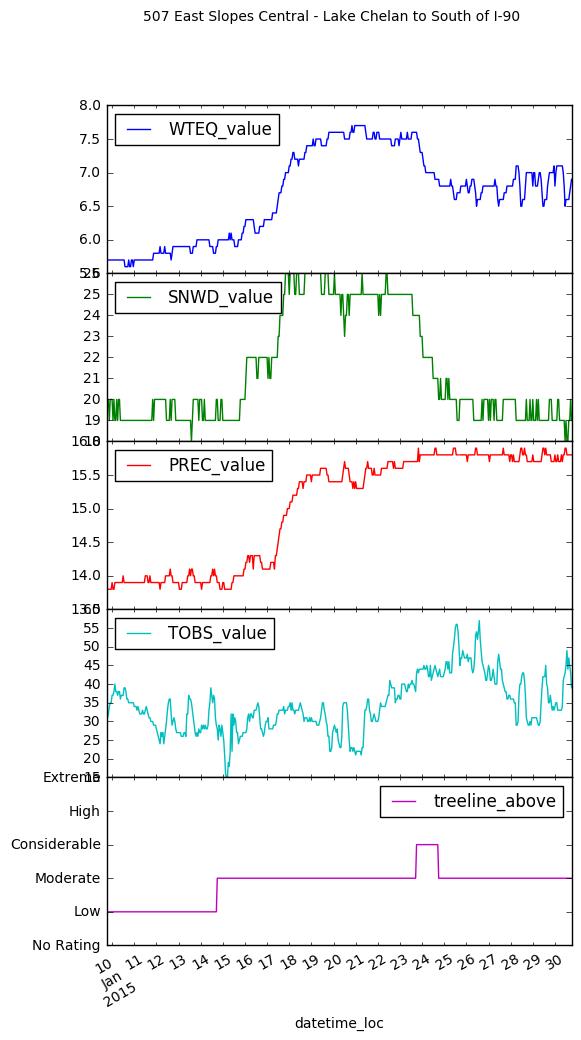

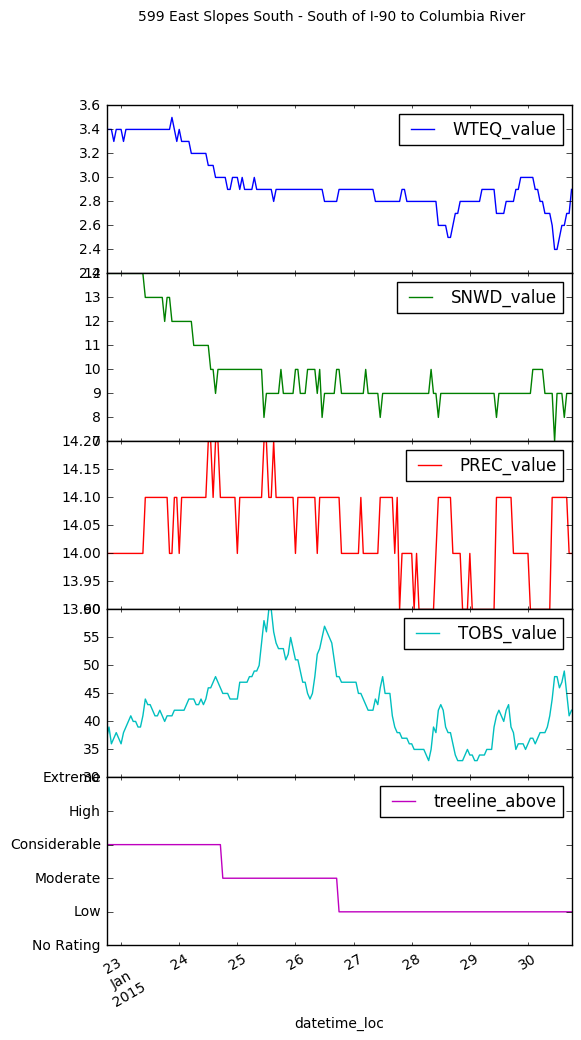

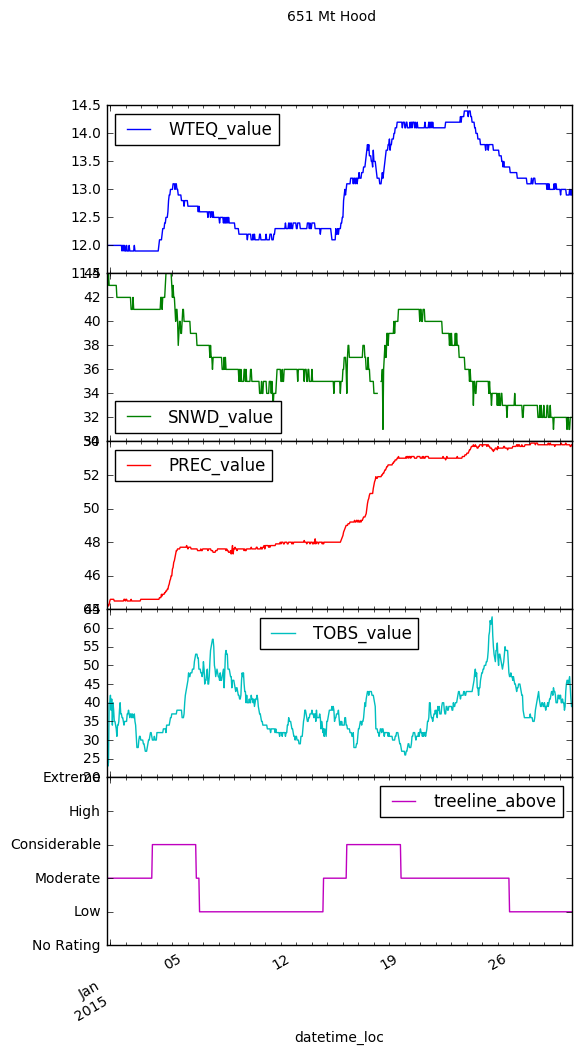

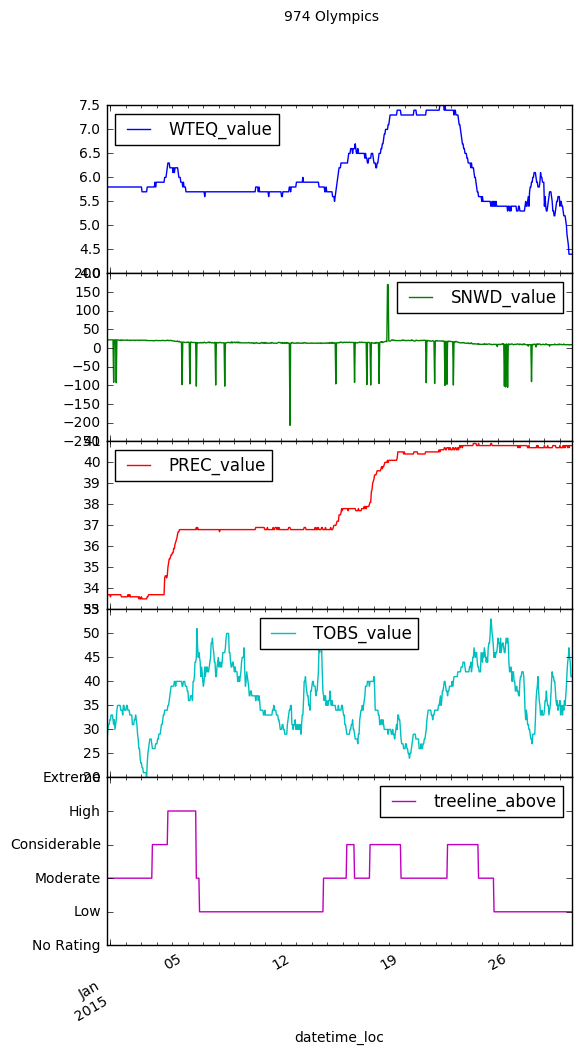

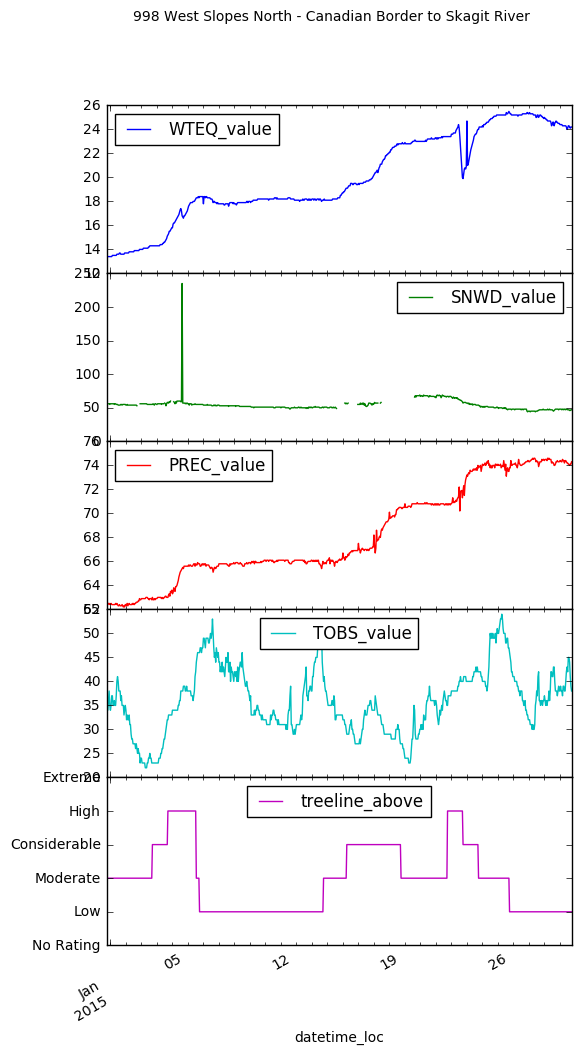

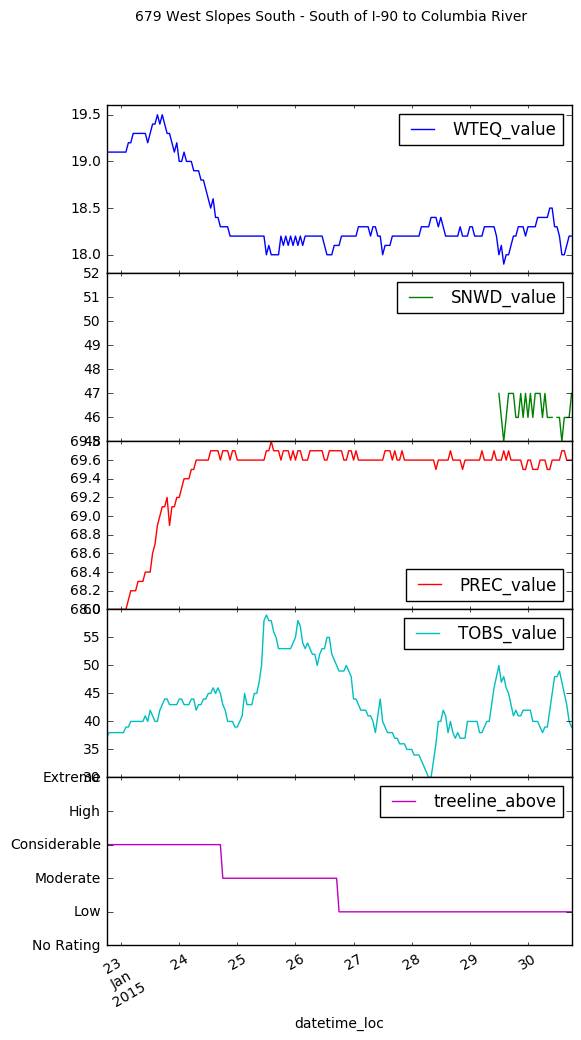

In [225]:
for (region,site_id),dfx in dfsa.groupby(level=[0,1]):
    
    plt.figure()
    
    
    dfx.index = dfx.index.droplevel(0).droplevel(0)
    dfx = dfx[plotcols]
    
    
    axes = dfx.plot(subplots=True, figsize=(6,12), legend=True)
    plt.subplots_adjust(hspace=0)
    plt.suptitle('%d %s' % (site_id,region))

    #axes[-2].axhline(32, c='k', ls='--')
    axes[-1].set_ylim(-0,5);
    axes[-1].set_yticklabels(ratings)
    #axes[-1].lines[0].set_marker('o')

    #plt.savefig('jan2015.pdf')
#dfx

# Daily binning

feature engineering: make this into scatter plots

In [ ]:
def make_engineered_features(usda_df, nwac_usda_df):
    
    features = {
        'treeline_above': nwac_usda_df.replace(ratings_to_numbers)['treeline_above'].resample('1D', how='last'),
        'precip_today': usda_df['Precipitation Accumulation (in)'].resample('1D').diff(),
        'snowdep':      usda_df['Snow Depth (in)'].resample('1D'),
        'watereq':      usda_df['Snow Water Equivalent (in)'].resample('1D'),
        'avgtemp':      usda_df['Air Temperature Observed (degF)'].resample('1D'),
    }
    
    features['tempchange'] = features['avgtemp'].diff()
    # pseudo-density: don't divide by zero
    features['density'] = features['watereq'] / (features['snowdep'] + 1)

    engineered = pd.DataFrame(features)

    return engineered


In [ ]:
def data_for_range(range_min, range_max):
    dfa = get_usda_hourly(651, range_min,range_max)
    dfb = fetch_nwac_ratings(range_min, range_max)
    return make_engineered_features(dfa, dfb)

In [ ]:
engineered = data_for_range(range_min, range_max)

engineered.plot(subplots=True)
plt.subplots_adjust(hspace=0)

In [ ]:
engineered.columns

In [393]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']
colors = ['gray', 'green', 'yellow', 'orange', 'red', 'black']
coldict = {rating:color for rating, color in zip(ratings, colors)}

numdict = {i:color for i, color in enumerate(colors)}
labdict = {i:rating for i, rating in enumerate(ratings)}
coldict

{'Considerable': 'orange',
 'Extreme': 'black',
 'High': 'red',
 'Low': 'green',
 'Moderate': 'yellow',
 'No Rating': 'gray'}

In [394]:
def plot_classes(engineered, x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    for val,subdf in engineered.groupby('treeline_above'):
        subdf.plot(kind='scatter',
                    x=x, y=y,
                    c=numdict.get(val, 'm'),
                    label=labdict.get(val, val),
                    ax=ax)
    ax.legend(loc='upper left', ncol=2)
 

In [ ]:
plot_classes(engineered,
             x='snowdep', y='precip_today')

# much more data

In [ ]:
engineered2 = data_for_range(pd.datetime(2013,11,1),
                            pd.datetime(2015,5,1))

In [ ]:
plot_classes(engineered2, x='snowdep', y='precip_today')

In [ ]:
plot_classes(engineered2, x='avgtemp', y='precip_today')

In [ ]:
plot_classes(engineered2, y='snowdep', x='watereq')

binning by the day is probably a bad approach. for each avalanche report, we should construct a time window extending 24 hours (or whatever) back in time from the date the report was issued. This would avoid sampling future data, and also avoid 2 reports on the same day getting their numerical values averaged

TODO!

# fit some models!

In [ ]:
from sklearn import svm
from sklearn import metrics

In [ ]:
def split_set(training_set):
    label = 'treeline_above'
    predictors = ['avgtemp', 'density', 'precip_today', 'snowdep', 'tempchange', 'watereq']

    mask = training_set[predictors + [label,]].isnull().any(axis=1)

    train = training_set[predictors]
    target = training_set[label]
    
    train_masked = train[~mask].values
    target_masked = target[~mask].values
    
    return train_masked, target_masked

def train_model(model, training_set):
    train_masked, target_masked = split_set(training_set)
    
    # this returns itself
    model = model.fit(train_masked, target_masked)
    
    result = model.predict(train_masked)
    training_score = metrics.accuracy_score(target_masked, result)
    
    return model, training_score

In [ ]:
from sklearn.linear_model import LogisticRegression
model, score = train_model(LogisticRegression(C = 1e3, penalty='l2'), engineered2)
score

# validation data

In [ ]:
validation = data_for_range(pd.datetime(2015,11,1),
                            pd.datetime(2016,2,1))

In [ ]:
plot_classes(validation, x='avgtemp', y='precip_today')

In [ ]:
plot_classes(validation, y='snowdep', x='watereq')

In [ ]:
valid_masked, target_masked = split_set(validation)

result = model.predict(valid_masked)
score = metrics.accuracy_score(target_masked, result)

score

# try svc

In [ ]:
from sklearn.svm import SVC
model, score = train_model(SVC(C = 1e3, kernel='linear'), engineered2)
score

In [ ]:
valid_masked, target_masked = split_set(validation)

result = model.predict(valid_masked)
score = metrics.accuracy_score(target_masked, result)

score

both scores dropped; I think this means that we need more dimensions to the data (not more advanced models)

# try daily data

In [229]:
import numpy as np

def p2f(x):
    try:
        val = float(x.strip('%'))
    except ValueError:
        val = np.nan
    return val

In [236]:
def get_usda_daily(site, range_min, range_max, state='WA'):
    # all USDA times are LOCAL TIME (PDT/PST)

    cols = [
        ('WTEQ','value'),
        ('WTEQ','pctOfMedian_1981'),
        ('SNWD','value'),
        ('PREC','value'),
        ('PREC','pctOfMedian_1981'),
        ('TMAX','value'),
        ('TMIN','value'),
        ('TAVG','value'),
        ]

    colstring = ','.join('{}::{}'.format(name,avg) for name,avg in cols)
    coltitles = ['Date',] + list('{}_{}'.format(name,avg) for name,avg in cols)
    
    converters = {'Snow Water Equivalent % of Median (1981-2010)': p2f,
                  'Precipitation Accumulation % of Median (1981-2010)': p2f}

    fmt = ('http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/'
           'customSingleStationReport/daily/{site}:{state}:SNTL/{range_min},{range_max}/{columns}')

    # convert these to strings.
    # the bound granularity is only by day, not by hour.
    range_min, range_max = (bound.strftime('%Y-%m-%d')
                            for bound in (range_min, range_max))

    url = fmt.format(range_min=range_min,
                     range_max=range_max,
                     columns=colstring, site=site, state=state)
    
    r = requests.get(url)

    # parse dataframe
    df = pd.read_csv(io.StringIO(r.text), comment='#',
                    converters=converters)
    
    # shorten column labels
    collabels = df.columns
    df.columns = coltitles
    
    # cheat sheet for column labels
    for a,b in zip(coltitles,collabels):
        pass
        #print("{}:{}".format(a,b))

    # as far as I can tell, dates are in pacific time. No idea whether DST is accounted for
    df['datetime_loc'] = pd.to_datetime(df['Date'])
    #df['date_utc'] = pd.to_datetime(df['Date'] + ' PST')
    df = df.set_index('datetime_loc')
    return df, collabels, url

In [318]:
daily_table = sa.Table('usda_daily', metadata,
                        sa.Column('site_id', sa.Integer,
                                  primary_key=True, autoincrement=False),
                          sa.Column('datetime_loc', sa.Date,
                                  primary_key=True, autoincrement=False),
                          sa.Column('WTEQ_value', sa.Float),
                          sa.Column('WTEQ_pctOfMedian_1981', sa.Float),
                          sa.Column('SNWD_value', sa.Float),
                          sa.Column('PREC_value', sa.Float),
                          sa.Column('PREC_pctOfMedian_1981', sa.Float),
                          sa.Column('TMAX_value', sa.Float),
                          sa.Column('TMIN_value', sa.Float),
                          sa.Column('TAVG_value', sa.Float),
                        )

In [319]:
#daily_table.create(engine)

df.to_sql(con=con, name='tablename_temp', if_exists='replace')
connection = con.connect()
connection.execute(text("""INSERT INTO tablename SELECT * FROM tablename_temp
                        ON DUPLICATE KEY UPDATE tablename.field_to_update=tablename_temp.field_to_update"""))
connection.execute(text('DROP TABLE tablename_temp '))

In [337]:
def store_usda_daily(df, site_id):
    dfins = df.drop('Date', axis=1)
    dfins['site_id'] = site_id
    dfins.to_sql('usda_daily', engine, if_exists='append')

In [338]:
def scrape_usda_daily(range_min, range_max, site_id):
    # scrape the data
    state = ref['state'].ix[site_id]
    df,collabels,url = get_usda_daily(site_id, range_min, range_max, state=state)
    # store it
    store_usda_daily(df, site_id)

In [339]:
ref.index

Int64Index([651, 974, 998, 507, 679, 599], dtype='int64', name='site_id')

In [ ]:
scrape_usda_daily(range_min, range_max, 599)

In [362]:
def fetch_usda_daily(range_min, range_max, site_id):
    # this database uses local time
    stmt = sa.select([daily_table]
                    ).where(
                        daily_table.c.site_id == site_id
                    ).where(
                        daily_table.c.datetime_loc <= range_max
                    ).where(
                        daily_table.c.datetime_loc >= range_min
                    ).order_by(daily_table.c.datetime_loc)

    df2 = pd.read_sql_query(stmt, engine)
    df2['datetime_loc'] = pd.to_datetime(df2['datetime_loc'])
    df2 = df2.set_index('datetime_loc')
    return df2

In [363]:
dfdb = fetch_usda_daily(range_min, range_max, 651)
dfdb.head()

,site_id,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,,
2013-11-01,651,0.2,20,0,4.3,60,49,33,41
2013-11-02,651,0.1,10,0,4.3,55,44,27,33
2013-11-03,651,0.9,82,3,5.6,69,29,26,28
2013-11-04,651,2.2,169,12,6.7,81,34,28,31
2013-11-05,651,2.8,187,15,7.4,85,38,33,36


In [347]:
dfdb = fetch_usda_daily(range_min, range_max, 974)
dfdb.head()

,site_id,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,,
2013-11-01,974,0.0,0,0,1.6,28,46,20,39
2013-11-02,974,0.0,0,0,1.6,28,38,28,32
2013-11-03,974,0.8,160,5,2.4,41,32,21,26
2013-11-04,974,1.0,200,5,2.6,41,35,18,27
2013-11-05,974,1.0,200,5,2.6,37,37,29,34


In [325]:
df.drop?

In [232]:
range_min,range_max = pd.datetime(2013,11,1), pd.datetime(2015,8,1)

In [243]:
def data_for_site(site_id):
    state = ref['state'].ix[site_id]
    df,collabels, url = get_usda_daily(site_id, range_min, range_max, state=state)
    return df

In [349]:
df = dfdb

In [350]:
df.head()

,site_id,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value
datetime_loc,,,,,,,,,
2013-11-01,974,0.0,0,0,1.6,28,46,20,39
2013-11-02,974,0.0,0,0,1.6,28,38,28,32
2013-11-03,974,0.8,160,5,2.4,41,32,21,26
2013-11-04,974,1.0,200,5,2.6,41,35,18,27
2013-11-05,974,1.0,200,5,2.6,37,37,29,34


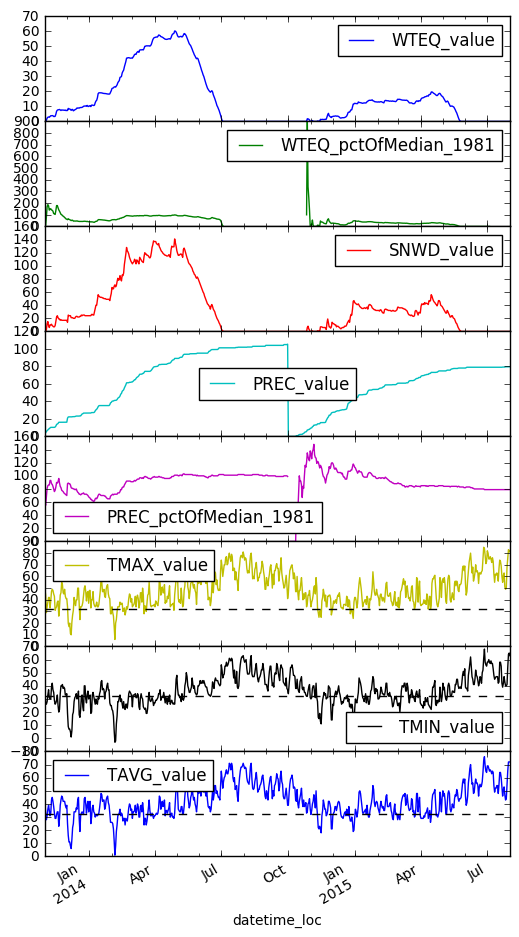

In [244]:
df = data_for_site(651)

axes = df.plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)
for ax in axes[-3:]:
    ax.axhline(32, c='k', ls='--')

In [309]:
nwac_areas = ['treeline_%s' % s for s in ('above', 'near', 'below')]

def resample_nwac_data(dffml):
    """ converts to numbers too """
    nwac_resampled = dffml.replace(ratings_to_numbers)[nwac_areas].resample('1D', how='last')
    return nwac_resampled

def incorporate_nwac_data(df, site_id):
    #look up the relevant nwac region
    region = ref['nwac_region'].ix[site_id]
    #query db for ratings from that region
    dffml = fetch_nwac_ratings_localtime(range_min, range_max, region=region)
    # graft it on
    nwac_resampled = resample_nwac_data(dffml)
    #return df, nwac_resampled
    df_result = pd.concat([df, nwac_resampled])
    return df_result

In [312]:
dffml = incorporate_nwac_data(df, 651)
dffml.head()

,Date,PREC_pctOfMedian_1981,PREC_value,SNWD_value,TAVG_value,TMAX_value,TMIN_value,WTEQ_pctOfMedian_1981,WTEQ_value,treeline_above,treeline_below,treeline_near
datetime_loc,,,,,,,,,,,,
2013-11-01,2013-11-01,60,4.3,0,41,49,33,20,0.2,NaN,NaN,NaN
2013-11-02,2013-11-02,55,4.3,0,33,44,27,10,0.1,NaN,NaN,NaN
2013-11-03,2013-11-03,69,5.6,3,28,29,26,82,0.9,NaN,NaN,NaN
2013-11-04,2013-11-04,81,6.7,12,31,34,28,169,2.2,NaN,NaN,NaN
2013-11-05,2013-11-05,85,7.4,15,36,38,33,187,2.8,NaN,NaN,NaN


In [282]:
dffml

,datetime_utc,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_loc,,,,,,,,,
2014-01-12 18:13:00,2014-01-13 02:13:00,275,"6:13 PM PST Sunday, January 12, 2014",Dennis D'Amico,Mt Hood,The avalanche danger should tick down a notch ...,Considerable,Considerable,Moderate
2014-01-12 18:22:00,2014-01-13 02:22:00,279,"6:22 PM PST Sunday, January 12, 2014",Dennis D'Amico,Mt Hood,The avalanche danger should tick down a notch ...,Considerable,Considerable,Moderate
2014-01-13 18:00:00,2014-01-14 02:00:00,283,"6:00 PM PST Monday, January 13, 2014",Kenny Kramer,Mt Hood,The avalanche danger should continue to slowly...,Moderate,Moderate,Moderate
2014-01-14 18:00:00,2014-01-15 02:00:00,287,"6:00 PM PST Tuesday, January 14, 2014",Kenny Kramer,Mt Hood,The avalanche danger should continue to slowly...,Moderate,Moderate,Moderate
2014-01-16 10:48:00,2014-01-16 18:48:00,294,"10:48 AM PST Thursday, January 16, 2014",Dennis D'Amico,Mt Hood,The avalanche danger should continue to slowly...,Moderate,Moderate,Moderate
2014-01-16 18:10:00,2014-01-17 02:10:00,302,"6:10 PM PST Thursday, January 16, 2014",Dennis D'Amico,Mt Hood,The Bottom Line: The name of the game on Frida...,Moderate,Moderate,Moderate
2014-01-17 18:04:00,2014-01-18 02:04:00,308,"6:04 PM PST Friday, January 17, 2014",Dennis D'Amico,Mt Hood,The Bottom Line: Watch for wet-loose slides o...,Moderate,Moderate,Low
2014-01-18 18:00:00,2014-01-19 02:00:00,311,"6:00 PM PST Saturday, January 18, 2014",Kenny Kramer,Mt Hood,"The Bottom Line: While slightly cooler, conti...",Low,Low,Low
2014-01-19 18:00:00,2014-01-20 02:00:00,314,"6:00 PM PST Sunday, January 19, 2014",Kenny Kramer,Mt Hood,The Bottom Line: Gradual warming and light wi...,Moderate,Moderate,Low


In [251]:
df.columns

Index(['Date', 'WTEQ_value', 'WTEQ_pctOfMedian_1981', 'SNWD_value',
       'PREC_value', 'PREC_pctOfMedian_1981', 'TMAX_value', 'TMIN_value',
       'TAVG_value', 'nwac'],
      dtype='object')

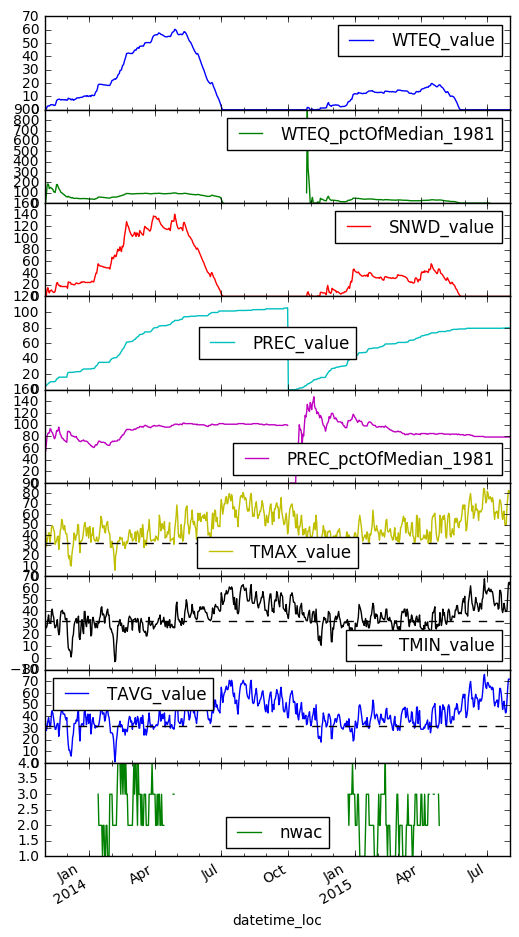

In [252]:
axes = df.plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)
for ax in axes[-4:-1]:
    ax.axhline(32, c='k', ls='--')

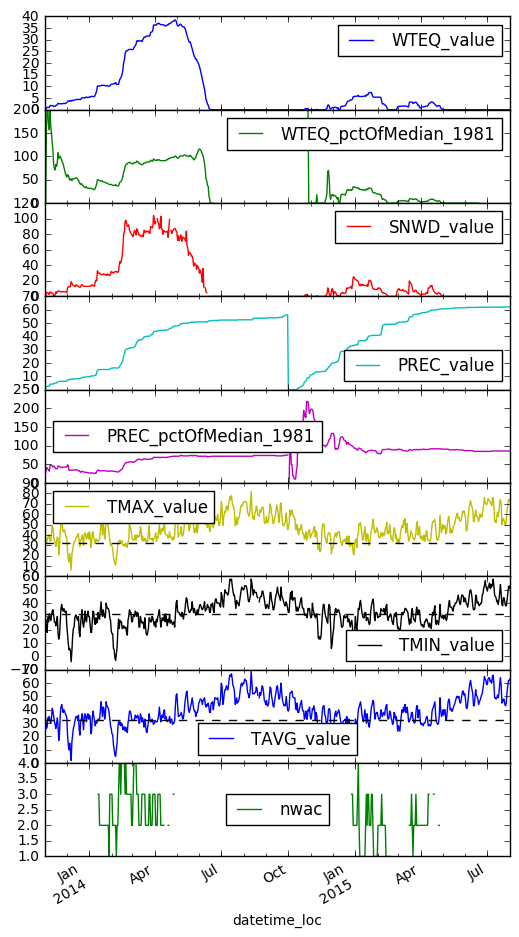

In [258]:
def all_data_for_site(site_id = 974):
    region = ref['nwac_region'].ix[site_id]

    df = incorporate_nwac_data(data_for_site(site_id),
                               fetch_nwac_ratings_localtime(range_min, range_max, region=region))
    
    return df

df = all_data_for_site(974)

axes = df.plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)
for ax in axes[-4:-1]:
    ax.axhline(32, c='k', ls='--')

# Making engineered features (daily data)

 - all present day values (except precip)
 - precip since yesterday
 - yesterday's temp trends
 - precip since 2 days ago
 - temp trends from 2 days ago
 - change in snow depth since yesterday
 
we need to do this *before* we adjoint the NWAC ratings

In [ ]:
df = data_for_site(651)
df.head()

In [272]:
df.columns

Index(['Date', 'WTEQ_value', 'WTEQ_pctOfMedian_1981', 'SNWD_value',
       'PREC_value', 'PREC_pctOfMedian_1981', 'TMAX_value', 'TMIN_value',
       'TAVG_value'],
      dtype='object')

In [260]:
len(df)

639

In [261]:
def make_engineered_daily(df):
    temps = ['TMAX_value', 'TMIN_value', 'TAVG_value',]

    current = temps + [
        'SNWD_value', 'WTEQ_value',
        'PREC_pctOfMedian_1981', 'WTEQ_pctOfMedian_1981'
    ]

    dfe = df[current]

    #these throw a bunch of warnings but I think it's ok
    dfe['TAVG_yest'] = df['TAVG_value'].shift(-1) # avg temp yesterday
    dfe['SNWD_1day'] = df['SNWD_value'].diff(-1) # 1 day snow depth diff
    dfe['SNWD_3day'] = df['SNWD_value'].diff(-3) # 3 day snow depth diff
    dfe['PREC_1day'] = df['PREC_value'].diff(-1) # 1 day precip diff

    return dfe

dfe = make_engineered_daily(df)
print(len(dfe))
dfe.head()

639


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,TMAX_value,TMIN_value,TAVG_value,SNWD_value,WTEQ_value,PREC_pctOfMedian_1981,WTEQ_pctOfMedian_1981,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,,,,,
2013-11-01,49,33,41,0,0.2,60,20,33,0,-12,0.0
2013-11-02,44,27,33,0,0.1,55,10,28,-3,-15,-1.3
2013-11-03,29,26,28,3,0.9,69,82,31,-9,-6,-1.1
2013-11-04,34,28,31,12,2.2,81,169,36,-3,6,-0.7
2013-11-05,38,33,36,15,2.8,85,187,39,6,5,-1.0


now, get equivalent range of ratings from nwac and make an 'adjoint' data frame

In [264]:
df2 = fetch_nwac_ratings_localtime(range_min, range_max)
print(len(df2))
df2.head()

254


,datetime_utc,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_loc,,,,,,,,,
2014-01-12 18:13:00,2014-01-13 02:13:00,275,"6:13 PM PST Sunday, January 12, 2014",Dennis D'Amico,Mt Hood,The avalanche danger should tick down a notch ...,Considerable,Considerable,Moderate
2014-01-12 18:22:00,2014-01-13 02:22:00,279,"6:22 PM PST Sunday, January 12, 2014",Dennis D'Amico,Mt Hood,The avalanche danger should tick down a notch ...,Considerable,Considerable,Moderate
2014-01-13 18:00:00,2014-01-14 02:00:00,283,"6:00 PM PST Monday, January 13, 2014",Kenny Kramer,Mt Hood,The avalanche danger should continue to slowly...,Moderate,Moderate,Moderate
2014-01-14 18:00:00,2014-01-15 02:00:00,287,"6:00 PM PST Tuesday, January 14, 2014",Kenny Kramer,Mt Hood,The avalanche danger should continue to slowly...,Moderate,Moderate,Moderate
2014-01-16 10:48:00,2014-01-16 18:48:00,294,"10:48 AM PST Thursday, January 16, 2014",Dennis D'Amico,Mt Hood,The avalanche danger should continue to slowly...,Moderate,Moderate,Moderate


In [265]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']

In [ ]:
# convert to a numerical rating
ratdict = {rat:i for i,rat in enumerate(ratings)}

ratings_to_numbers = {'treeline_above':ratdict,
            'treeline_below':ratdict,
            'treeline_near':ratdict,}

In [442]:
ratings = resample_nwac_data(df2)[dfe.index] # this takes care of converting 'moderate' to 2 etc
dfadj = pd.concat([ratings, dfe], axis=1)
dfadj.head()

,treeline_above,TMAX_value,TMIN_value,TAVG_value,SNWD_value,WTEQ_value,PREC_pctOfMedian_1981,WTEQ_pctOfMedian_1981,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
date_loc,,,,,,,,,,,,
2013-11-01,NaN,49,33,41,0,0.2,60,20,33,0,-12,0.0
2013-11-02,NaN,44,27,33,0,0.1,55,10,28,-3,-15,-1.3
2013-11-03,NaN,29,26,28,3,0.9,69,82,31,-9,-6,-1.1
2013-11-04,NaN,34,28,31,12,2.2,81,169,36,-3,6,-0.7
2013-11-05,NaN,38,33,36,15,2.8,85,187,39,6,5,-1.0


In [443]:
len(dfadj)

639

In [389]:
def remove_null_rows(df):
    mask = df.isnull().any(axis=1)
    return df[~mask]

In [445]:
dfclean = remove_null_rows(dfadj)

In [446]:
len(dfadj), len(dfclean)

(639, 203)

limit ourselves to only extreme values

In [484]:
mask = (dfclean['treeline_above'] == 1) | (dfclean['treeline_above'] == 4)
dflimit = dfclean[mask]
dflimit.head()

,treeline_above,TMAX_value,TMIN_value,TAVG_value,SNWD_value,WTEQ_value,PREC_pctOfMedian_1981,WTEQ_pctOfMedian_1981,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
date_loc,,,,,,,,,,,,
2014-01-18,1,55,44,47,52,19.0,70,57,42,1,2,0
2014-01-21,1,49,37,43,50,18.7,70,55,36,0,1,0
2014-01-22,1,43,30,36,50,18.6,69,54,38,0,1,0
2014-01-25,1,52,40,45,49,18.4,66,51,46,0,0,0
2014-01-26,1,53,42,46,49,18.3,65,50,41,0,2,0


In [505]:
dflimit.columns

Index(['treeline_above', 'TMAX_value', 'TMIN_value', 'TAVG_value',
       'SNWD_value', 'WTEQ_value', 'PREC_pctOfMedian_1981',
       'WTEQ_pctOfMedian_1981', 'TAVG_yest', 'SNWD_1day', 'SNWD_3day',
       'PREC_1day'],
      dtype='object')

In [351]:
fetch_usda_daily??

In [359]:
dfe.index

DatetimeIndex(['2013-11-01', '2013-11-02', '2013-11-03', '2013-11-04',
               '2013-11-05', '2013-11-06', '2013-11-07', '2013-11-08',
               '2013-11-09', '2013-11-10',
               ...
               '2015-07-23', '2015-07-24', '2015-07-25', '2015-07-26',
               '2015-07-27', '2015-07-28', '2015-07-29', '2015-07-30',
               '2015-07-31', '2015-08-01'],
              dtype='datetime64[ns]', name='datetime_loc', length=639, freq=None)

In [361]:
pd.to_datetime(dfdb.index)

DatetimeIndex(['2013-11-01', '2013-11-02', '2013-11-03', '2013-11-04',
               '2013-11-05', '2013-11-06', '2013-11-07', '2013-11-08',
               '2013-11-09', '2013-11-10',
               ...
               '2015-07-23', '2015-07-24', '2015-07-25', '2015-07-26',
               '2015-07-27', '2015-07-28', '2015-07-29', '2015-07-30',
               '2015-07-31', '2015-08-01'],
              dtype='datetime64[ns]', name='datetime_loc', length=639, freq=None)

In [380]:
site_id = 651
df = fetch_usda_daily(range_min, range_max, site_id).drop('site_id', axis=1)
dfe = make_engineered_daily(df)
dfe.head()
region = ref['nwac_region'].ix[site_id]
df2 = fetch_nwac_ratings_localtime(range_min, range_max, region=region)
resampled = resample_nwac_data(df2)

In [384]:
dfe.index[0] in resampled.index

False

In [387]:
pd.concat?

In [385]:
resampled.index[0] in dfe.index

True

In [375]:
dfe.index

DatetimeIndex(['2013-11-01', '2013-11-02', '2013-11-03', '2013-11-04',
               '2013-11-05', '2013-11-06', '2013-11-07', '2013-11-08',
               '2013-11-09', '2013-11-10',
               ...
               '2015-07-23', '2015-07-24', '2015-07-25', '2015-07-26',
               '2015-07-27', '2015-07-28', '2015-07-29', '2015-07-30',
               '2015-07-31', '2015-08-01'],
              dtype='datetime64[ns]', name='datetime_loc', length=639, freq=None)

In [376]:
df2.index

DatetimeIndex(['2014-01-12 18:13:00', '2014-01-12 18:22:00',
               '2014-01-13 18:00:00', '2014-01-14 18:00:00',
               '2014-01-16 10:48:00', '2014-01-16 18:10:00',
               '2014-01-17 18:04:00', '2014-01-18 18:00:00',
               '2014-01-19 18:00:00', '2014-01-20 18:00:00',
               ...
               '2015-04-06 18:00:00', '2015-04-07 18:00:00',
               '2015-04-08 18:00:00', '2015-04-09 18:00:00',
               '2015-04-10 18:00:00', '2015-04-11 18:00:00',
               '2015-04-17 18:00:00', '2015-04-18 18:00:00',
               '2015-04-24 18:00:00', '2015-04-25 18:00:00'],
              dtype='datetime64[ns]', name='datetime_loc', length=254, freq=None)

In [390]:
def cleaning_pipeline(site_id, range_min, range_max):
    df = fetch_usda_daily(range_min, range_max, site_id).drop('site_id', axis=1)
    dfe = make_engineered_daily(df)
    # get nwac ratings from db
    region = ref['nwac_region'].ix[site_id]
    df2 = fetch_nwac_ratings_localtime(range_min, range_max, region=region)
    # resample to daily and make ratings numerical
    ratings = resample_nwac_data(df2)
    dfadj = pd.concat([ratings, dfe], axis=1)
    dfclean = remove_null_rows(dfadj)
    # only extreme values
    mask = (dfclean['treeline_above'] == 1) | (dfclean['treeline_above'] == 4)
    dflimit = dfclean[mask]
    return dflimit
    
dflimit = cleaning_pipeline(651, range_min, range_max)

In [391]:
dflimit.head()

,treeline_above,treeline_near,treeline_below,TMAX_value,TMIN_value,TAVG_value,SNWD_value,WTEQ_value,PREC_pctOfMedian_1981,WTEQ_pctOfMedian_1981,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,,,,,,,,
2014-01-18,1,1,1,55,44,47,52,19.0,70,57,42,1,2,0
2014-01-21,1,1,1,49,37,43,50,18.7,70,55,36,0,1,0
2014-01-22,1,1,1,43,30,36,50,18.6,69,54,38,0,1,0
2014-01-25,1,1,1,52,40,45,49,18.4,66,51,46,0,0,0
2014-01-26,1,1,1,53,42,46,49,18.3,65,50,41,0,2,0


In [396]:
ref.index

Int64Index([651, 974, 998, 507, 679, 599], dtype='int64', name='site_id')

In [409]:
dfes = [cleaning_pipeline(site_id, range_min, range_max) for site_id in (651, 974, 998, 507, 679, 599)]

In [412]:
len(dfes)

6

In [415]:
[len(dfees) for dfees in dfes]

[50, 39, 0, 0, 3, 5]

In [410]:
dflimit = pd.concat(dfes)

In [414]:
len(dflimit)

97

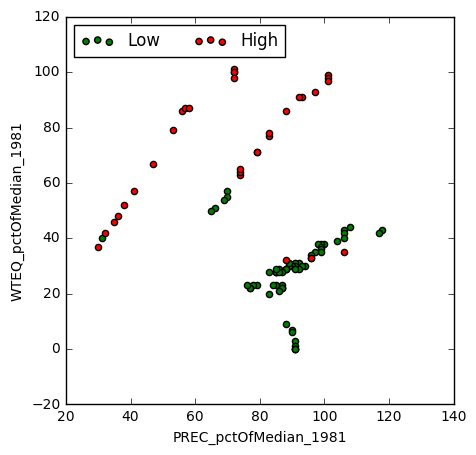

In [411]:
plot_classes(dflimit, x='PREC_pctOfMedian_1981', y='WTEQ_pctOfMedian_1981')

problem: segmentation by year and site

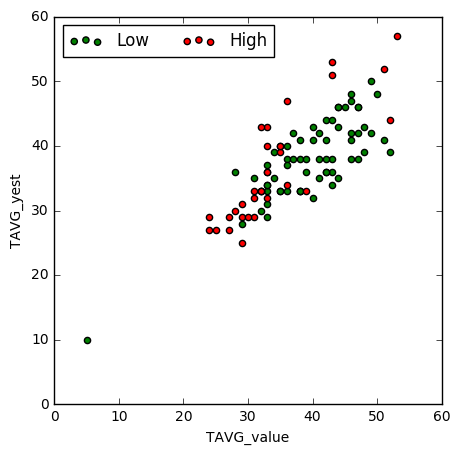

In [413]:
plot_classes(dflimit, x='TAVG_value', y='TAVG_yest')

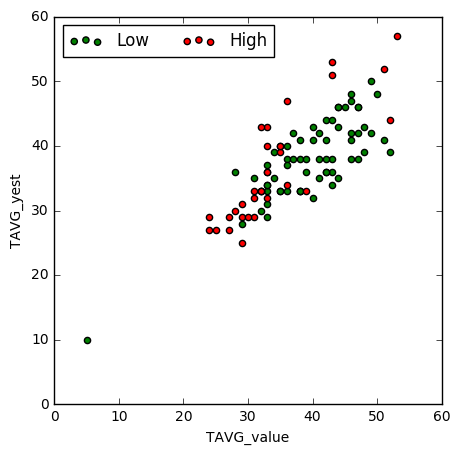

In [416]:
plot_classes(dflimit, x='TAVG_value', y='TAVG_yest')

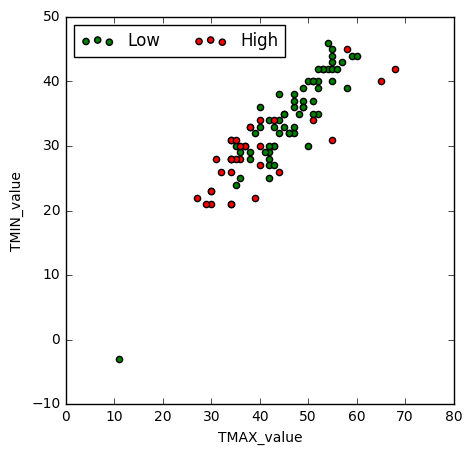

In [417]:
plot_classes(dflimit, x='TMAX_value', y='TMIN_value')

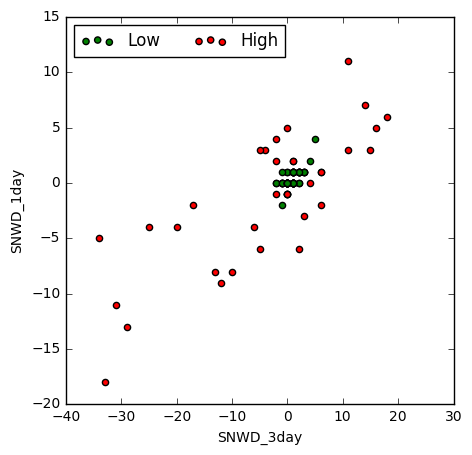

In [418]:
plot_classes(dflimit, x='SNWD_3day', y='SNWD_1day')

that's pretty good. clustering based on snow depth changing

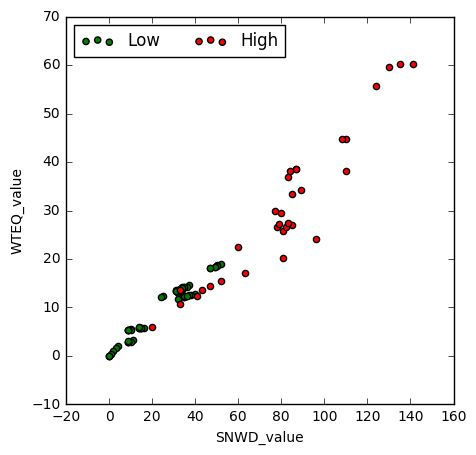

In [420]:
plot_classes(dflimit, x='SNWD_value', y='WTEQ_value')

potential problem: could give severe rating just based on snow being deep

# modeling

split into training and target sets

In [427]:
dftarget = dflimit['treeline_above']
dftarget.head()

datetime_loc
2014-01-18    1
2014-01-21    1
2014-01-22    1
2014-01-25    1
2014-01-26    1
Name: treeline_above, dtype: float64

In [429]:
ratings

['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']

In [431]:
nwac_areas

['treeline_above', 'treeline_near', 'treeline_below']

In [432]:
dftrain = dflimit.drop(nwac_areas, axis=1)
dftrain.head()

,TMAX_value,TMIN_value,TAVG_value,SNWD_value,WTEQ_value,PREC_pctOfMedian_1981,WTEQ_pctOfMedian_1981,TAVG_yest,SNWD_1day,SNWD_3day,PREC_1day
datetime_loc,,,,,,,,,,,
2014-01-18,55,44,47,52,19.0,70,57,42,1,2,0
2014-01-21,49,37,43,50,18.7,70,55,36,0,1,0
2014-01-22,43,30,36,50,18.6,69,54,38,0,1,0
2014-01-25,52,40,45,49,18.4,66,51,46,0,0,0
2014-01-26,53,42,46,49,18.3,65,50,41,0,2,0


principal component analysis

In [433]:
dftrain.values.shape # n_samples, n_features

(97, 11)

In [434]:
from sklearn.decomposition import PCA
pca = PCA()
pc = pca.fit_transform(dftrain.values)

In [435]:
pca.explained_variance_ratio_

array([  7.31501786e-01,   1.69049196e-01,   5.49340256e-02,
         2.00177554e-02,   1.33305032e-02,   4.61775503e-03,
         3.31381717e-03,   1.55084936e-03,   1.38894171e-03,
         2.29386691e-04,   6.59841080e-05])

In [436]:
dfp = pd.DataFrame(pc, index = dftrain.index)
dfp.head()

,0,1,2,3,4,5,6,7,8,9,10
datetime_loc,,,,,,,,,,,
2014-01-18,15.109513,-1.190308,23.269941,-1.499881,-0.572944,3.545685,-2.322443,-0.513904,-0.687602,-1.382175,-0.138114
2014-01-21,12.917870,5.362231,14.257695,0.573198,1.063404,4.718846,0.037695,-1.362427,-0.611749,0.480975,-0.244993
2014-01-22,13.064277,11.032550,7.010222,4.883315,1.421453,-1.118169,0.006587,-0.278193,0.447282,0.003339,-0.333946
2014-01-25,9.848532,4.316049,21.790453,-0.791099,-4.213168,-2.413846,-2.296995,0.161872,-0.533865,-0.203001,-0.317566
2014-01-26,9.157758,4.722779,22.458699,-0.095685,-5.005620,3.209408,-1.954915,-1.331698,-1.316015,-0.672056,-0.224078


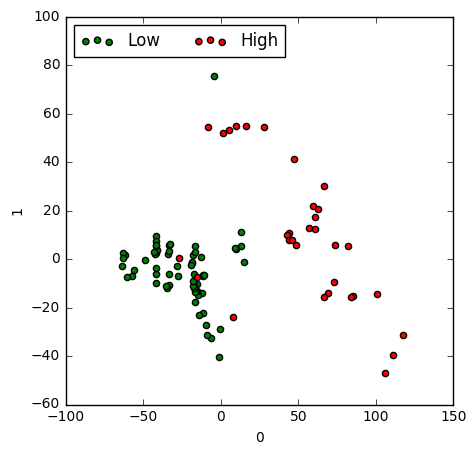

In [437]:
plot_classes(pd.concat([dftarget, dfp], axis=1), x=0, y=1)

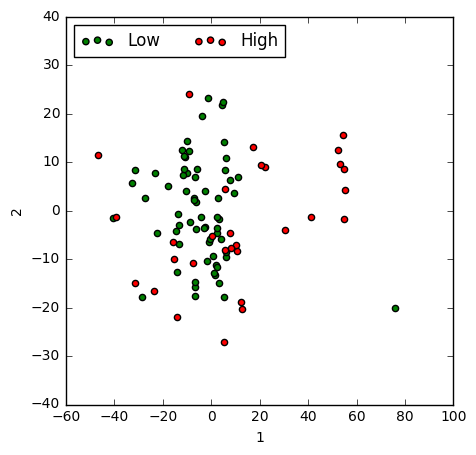

In [438]:
plot_classes(pd.concat([dftarget, dfp], axis=1), x=1, y=2)

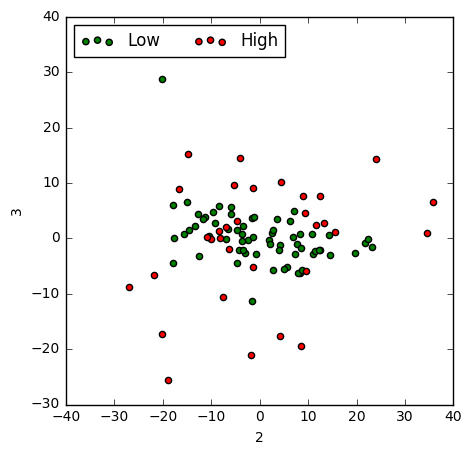

In [439]:
plot_classes(pd.concat([dftarget, dfp], axis=1), x=2, y=3)

# train model

without using PCA

In [440]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C = 1e3, penalty='l2')

model.fit(dftrain, dftarget)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [442]:
from sklearn import metrics
result = model.predict(dftrain)
metrics.accuracy_score(dftarget, result)

1.0

In [443]:
np.mean(result == dftarget.values)

1.0

mega overfitted... again

# cross validation

In [444]:
len(dftarget)

97

In [445]:
from sklearn.cross_validation import KFold

kf = KFold(len(dftarget), n_folds=4)
for train, test in kf:
    
    model = LogisticRegression(C = 1e3, penalty='l2')
    model.fit(dftrain.ix[train], dftarget.ix[train])
    
    result = model.predict(dftrain.ix[test])
    score = metrics.accuracy_score(dftarget.ix[test], result)
    print(score)

0.76
0.958333333333
0.791666666667
1.0


wow! works really well... seemingly.

# old stuff

In [ ]:
def recent_diff

In [205]:
mydate = pd.Period('2015-01-05')

In [206]:
mydate = pd.to_datetime('2015-01-05')

In [207]:
mydate

Timestamp('2015-01-05 00:00:00')

In [208]:
day = pd.Timedelta('1 day')

In [211]:
mydate - day

Timestamp('2015-01-04 00:00:00')

In [212]:
df.index.max(), df.index.max()

(Timestamp('2015-01-31 00:00:00'), Timestamp('2015-01-31 00:00:00'))

In [213]:
today = df.ix[mydate]
today

Date                     2015-01-05
WTEQ_value                       13
WTEQ_pctOfMedian_1981            47
SNWD_value                       42
PREC_value                     46.4
PREC_pctOfMedian_1981           106
TMAX_value                       47
TMIN_value                       35
TAVG_value                       39
nwac                              3
Name: 2015-01-05 00:00:00, dtype: object

In [214]:
yesterday = df.ix[mydate - day]
yesterday

Date                     2015-01-04
WTEQ_value                     11.9
WTEQ_pctOfMedian_1981            44
SNWD_value                       41
PREC_value                     44.6
PREC_pctOfMedian_1981           104
TMAX_value                       37
TMIN_value                       31
TAVG_value                       33
nwac                              3
Name: 2015-01-04 00:00:00, dtype: object

In [215]:
today['WTEQ_value'] - yesterday['WTEQ_value']

1.0999999999999996

In [216]:
pd.concat([df['WTEQ_value'].diff(-1), df['WTEQ_value']], axis=1)

,WTEQ_value,WTEQ_value
date_loc,,
2014-12-31,0.1,12.1
2015-01-01,0.1,12.0
2015-01-02,0.0,11.9
2015-01-03,0.0,11.9
2015-01-04,-1.1,11.9
2015-01-05,0.3,13.0
2015-01-06,0.1,12.7
2015-01-07,0.1,12.6
2015-01-08,0.1,12.5


In [218]:
df['WTEQ_value'].diff(-1)

date_loc
2014-12-31    0.1
2015-01-01    0.1
2015-01-02    0.0
2015-01-03    0.0
2015-01-04   -1.1
2015-01-05    0.3
2015-01-06    0.1
2015-01-07    0.1
2015-01-08    0.1
2015-01-09    0.2
2015-01-10    0.1
2015-01-11   -0.2
2015-01-12    0.0
2015-01-13   -0.1
2015-01-14    0.1
2015-01-15   -0.2
2015-01-16   -0.7
2015-01-17   -0.3
2015-01-18   -0.4
2015-01-19   -0.2
2015-01-20    0.0
2015-01-21    0.0
2015-01-22   -0.1
2015-01-23   -0.2
2015-01-24    0.6
2015-01-25    0.1
2015-01-26    0.4
2015-01-27    0.2
2015-01-28    0.0
2015-01-29    0.1
2015-01-30    0.0
2015-01-31    NaN
Name: WTEQ_value, dtype: float64

In [164]:
#TODO: make engineered features by grabbing a couple days back

In [163]:
df

,Date,WTEQ_value,WTEQ_pctOfMedian_1981,SNWD_value,PREC_value,PREC_pctOfMedian_1981,TMAX_value,TMIN_value,TAVG_value,nwac
date_loc,,,,,,,,,,
2014-12-31,2014-12-31,12.1,49,44,44.6,113,42,22,29,3
2015-01-01,2015-01-01,12.0,47,43,44.6,112,42,30,36,2
2015-01-02,2015-01-02,11.9,46,42,44.6,109,39,28,34,2
2015-01-03,2015-01-03,11.9,45,41,44.6,107,33,27,30,2
2015-01-04,2015-01-04,11.9,44,41,44.6,104,37,31,33,3
2015-01-05,2015-01-05,13.0,47,42,46.4,106,47,35,39,3
2015-01-06,2015-01-06,12.7,44,40,47.6,108,54,46,49,2
2015-01-07,2015-01-07,12.6,43,38,47.6,106,59,44,50,1
2015-01-08,2015-01-08,12.5,42,37,47.6,106,54,42,48,1


In [131]:
def make_engineered_features_daily(df, daysback=1):
    
    nwac_resampled = nwac_usda_df.replace(ratings_to_numbers)['treeline_above'].resample('1D', how='last')
    
    return pd.concat([usda_df, nwac_resampled], axis=1)
    
    features = {
        'treeline_above': nwac_usda_df.replace(ratings_to_numbers)['treeline_above'].resample('1D', how='last'),
        'precip_today': usda_df['Precipitation Accumulation (in)'].resample('1D').diff(),
        'snowdep':      usda_df['Snow Depth (in)'].resample('1D'),
        'watereq':      usda_df['Snow Water Equivalent (in)'].resample('1D'),
        'avgtemp':      usda_df['Air Temperature Observed (degF)'].resample('1D'),
    }
    
    features['tempchange'] = features['avgtemp'].diff()
    # pseudo-density: don't divide by zero
    features['density'] = features['watereq'] / (features['snowdep'] + 1)

    engineered = pd.DataFrame(features)

    return engineered


In [132]:
make_engineered_features_daily(df2, fetch_nwac_ratings(range_min, range_max))

,datetime_utc,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below,treeline_above
2014-12-31 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2014-12-31 18:00:00,2015-01-01 02:00:00,994,"6:00 PM PST Wednesday, December 31, 2014",Kenny Kramer,Mt Hood,Recent N-NE winds have created some wind slab ...,Moderate,Moderate,Moderate,NaN
2015-01-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2015-01-01 18:00:00,2015-01-02 02:00:00,998,"6:00 PM PST Thursday, January 1, 2015",Garth Ferber,Mt Hood,Watch for lingering wind slab from early in th...,Moderate,Moderate,Moderate,NaN
2015-01-02 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2015-01-02 18:00:00,2015-01-03 02:00:00,1002,"6:00 PM PST Friday, January 2, 2015",Garth Ferber,Mt Hood,Watch mainly for lingering local wind slab fro...,Moderate,Moderate,Moderate,NaN
2015-01-03 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2015-01-03 17:52:00,2015-01-04 01:52:00,1006,"5:52 PM PST Saturday, January 3, 2015",Dennis D'Amico,Mt Hood,The avalanche danger will increase sharply by ...,Considerable,Considerable,Considerable,NaN
2015-01-04 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-01-04 17:35:00,2015-01-05 01:35:00,1010,"5:35 PM PST Sunday, January 4, 2015",Dennis D'Amico,Mt Hood,Dangerous avalanche conditions are expected Su...,Considerable,Considerable,Moderate,NaN


In [38]:
def data_for_range(range_min, range_max):
    dfa = get_usda_hourly(651, range_min,range_max)
    dfb = fetch_nwac_ratings(range_min, range_max)
    return make_engineered_features(dfa, dfb)

In [ ]:
make_engineered_features_daily(df2, )

# OLD

# slow models

In [ ]:
from sklearn.svm import SVC
model, score = train_model(SVC(C = 1e6, kernel='poly'), engineered2)
score

In [ ]:
from sklearn.svm import SVC
model, score = train_model(SVC(C = 1e6, kernel='rbf'), engineered2)
score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model, score = train_model(RandomForestClassifier(), engineered2)
score

# Ad hoc testing

In [166]:
model.predict([[30, .4, 0, 34, 0, 13], # no precip today
               [30, .4, 1, 34, 0, 13], # 1in precip today
              ])

array([ 1.,  3.])

seems reasonable.

In [167]:
from sklearn.externals import joblib
joblib.dump(model, 'filename.pkl') 

['filename.pkl',
 'filename.pkl_01.npy',
 'filename.pkl_02.npy',
 'filename.pkl_03.npy',
 'filename.pkl_04.npy']

# To do

- re-do this to select 24 hour window prior to each report
- routine which just grabs 24 hours prior to any given time
- validate model on some other set of data
- write a flask app

# Try re-training on daily data